In [ ]:
!pip install opencv-python>=3.4.2.17
!pip install libsvm>=3.23.0

In [ ]:
import collections
from itertools import chain
import urllib.request as request
import pickle 

import numpy as np
import pandas as pd

import scipy.signal as signal
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

import cv2

from libsvm import svmutil

In [ ]:
def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def gaussian_kernel2d(n, sigma):
    Y, X = np.indices((n, n)) - int(n/2)
    gaussian_kernel = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2)) 
    return normalize_kernel(gaussian_kernel)

def local_mean(image, kernel):
    return signal.convolve2d(image, kernel, 'same')

In [ ]:
def local_deviation(image, local_mean, kernel):
    "Vectorized approximation of local deviation"
    sigma = image ** 2
    sigma = signal.convolve2d(sigma, kernel, 'same')
    return np.sqrt(np.abs(local_mean ** 2 - sigma))

In [ ]:
def calculate_mscn_coefficients(image, kernel_size=6, sigma=7/6):
    C = 1/255
    kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
    local_mean = signal.convolve2d(image, kernel, 'same')
    local_var = local_deviation(image, local_mean, kernel)
    
    return (image - local_mean) / (local_var + C)

In [ ]:
def generalized_gaussian_dist(x, alpha, sigma):
    beta = sigma * np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    
    coefficient = alpha / (2 * beta() * special.gamma(1 / alpha))
    return coefficient * np.exp(-(np.abs(x) / beta) ** alpha)

In [ ]:
def calculate_pair_product_coefficients(mscn_coefficients):
    return collections.OrderedDict({
        'mscn': mscn_coefficients,
        'horizontal': mscn_coefficients[:, :-1] * mscn_coefficients[:, 1:],
        'vertical': mscn_coefficients[:-1, :] * mscn_coefficients[1:, :],
        'main_diagonal': mscn_coefficients[:-1, :-1] * mscn_coefficients[1:, 1:],
        'secondary_diagonal': mscn_coefficients[1:, :-1] * mscn_coefficients[:-1, 1:]
    })

In [ ]:
def asymmetric_generalized_gaussian(x, nu, sigma_l, sigma_r):
    def beta(sigma):
        return sigma * np.sqrt(special.gamma(1 / nu) / special.gamma(3 / nu))
    
    coefficient = nu / ((beta(sigma_l) + beta(sigma_r)) * special.gamma(1 / nu))
    f = lambda x, sigma: coefficient * np.exp(-(x / beta(sigma)) ** nu)
        
    return np.where(x < 0, f(-x, sigma_l), f(x, sigma_r))

In [ ]:
def asymmetric_generalized_gaussian_fit(x):
    def estimate_phi(alpha):
        numerator = special.gamma(2 / alpha) ** 2
        denominator = special.gamma(1 / alpha) * special.gamma(3 / alpha)
        return numerator / denominator

    def estimate_r_hat(x):
        size = np.prod(x.shape)
        return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)

    def estimate_R_hat(r_hat, gamma):
        numerator = (gamma ** 3 + 1) * (gamma + 1)
        denominator = (gamma ** 2 + 1) ** 2
        return r_hat * numerator / denominator

    def mean_squares_sum(x, filter = lambda z: z == z):
        filtered_values = x[filter(x)]
        squares_sum = np.sum(filtered_values ** 2)
        return squares_sum / ((filtered_values.shape))

    def estimate_gamma(x):
        left_squares = mean_squares_sum(x, lambda z: z < 0)
        right_squares = mean_squares_sum(x, lambda z: z >= 0)

        return np.sqrt(left_squares) / np.sqrt(right_squares)

    def estimate_alpha(x):
        r_hat = estimate_r_hat(x)
        gamma = estimate_gamma(x)
        R_hat = estimate_R_hat(r_hat, gamma)

        solution = optimize.root(lambda z: estimate_phi(z) - R_hat, [0.2]).x

        return solution[0]

    def estimate_sigma(x, alpha, filter = lambda z: z < 0):
        return np.sqrt(mean_squares_sum(x, filter))
    
    def estimate_mean(alpha, sigma_l, sigma_r):
        return (sigma_r - sigma_l) * constant * (special.gamma(2 / alpha) / special.gamma(1 / alpha))
    
    alpha = estimate_alpha(x)
    sigma_l = estimate_sigma(x, alpha, lambda z: z < 0)
    sigma_r = estimate_sigma(x, alpha, lambda z: z >= 0)
    
    constant = np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    mean = estimate_mean(alpha, sigma_l, sigma_r)
    
    return alpha, mean, sigma_l, sigma_r

In [ ]:
def calculate_brisque_features(image, kernel_size=7, sigma=7/6):
    def calculate_features(coefficients_name, coefficients, accum=np.array([])):
        alpha, mean, sigma_l, sigma_r = asymmetric_generalized_gaussian_fit(coefficients)

        if coefficients_name == 'mscn':
            var = (sigma_l ** 2 + sigma_r ** 2) / 2
            return [alpha, var]
        
        return [alpha, mean, sigma_l ** 2, sigma_r ** 2]
    
    mscn_coefficients = calculate_mscn_coefficients(image, kernel_size, sigma)
    coefficients = calculate_pair_product_coefficients(mscn_coefficients)
    
    features = [calculate_features(name, coeff) for name, coeff in coefficients.items()]
    flatten_features = list(chain.from_iterable(features))
    return np.array(flatten_features)

In [ ]:
def load_image(url):
    image_stream = request.urlopen(url)
    return skimage.io.imread(image_stream, plugin='pil')

def plot_histogram(x, label):
    n, bins = np.histogram(x.ravel(), bins=50)
    n = n / np.max(n)
    plt.plot(bins[:-1], n, label=label, marker='o')

## 1. Load image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/images_dataset (1).csv")

In [ ]:
df.head()

,path,image_name,output_label
0,/content/drive/MyDrive/Datasets/Unscript2K23/V...,PMI-471989-2_std.jpg,very_bad
1,/content/drive/MyDrive/Datasets/Unscript2K23/V...,TTP-19-1012_std_std.jpg,very_bad
2,/content/drive/MyDrive/Datasets/Unscript2K23/V...,PMI-477440-2_std.jpg,very_bad
3,/content/drive/MyDrive/Datasets/Unscript2K23/V...,PMI-474454-1_dot__std.jpg,very_bad
4,/content/drive/MyDrive/Datasets/Unscript2K23/V...,PMI-472000-1_std.jpg,very_bad


In [ ]:
pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image
import os

In [ ]:
# # folder path
path1='/content/drive/MyDrive/Datasets/Unscript2K23/Very_Bad_Images[Accuracy_75]'
path2='/content/drive/MyDrive/Datasets/Unscript2K23/Bad_Images[75 _Accuracy _ 85 ]'
path3='/content/drive/MyDrive/Datasets/Unscript2K23/Good_Images [85 _ Accuracy _ 95]'
path4='/content/drive/MyDrive/Datasets/Unscript2K23/very_good_images [Accuracy _ 95]'

# name of images
names1 = [ file for file in os.listdir(path1) ]
names2 = [ file for file in os.listdir(path2) ]
names3 = [ file for file in os.listdir(path3) ]
names4 = [ file for file in os.listdir(path4) ]
# len(names1)
# entire path directiory of a single image
images1 = [ path1+names1[i] for i in range(len(names1))]
images2 = [ path2+names2[i] for i in range(len(names2))]
images3 = [ path3+names3[i] for i in range(len(names3))]
images4 = [ path4+names4[i] for i in range(len(names4))]

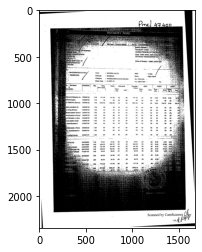

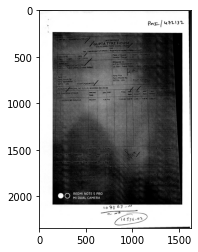

In [ ]:
# to display images
images = [ Image.open(path1+'/'+names1[i]) for i in range (3)]
# plt.figure()
plt.subplot(1,1,1),plt.imshow(images[0], cmap = 'gray')
plt.show()
plt.subplot(1,2,2),plt.imshow(images[1], cmap = 'gray')
plt.show()


In [ ]:
img1= Image.open(path1+'/'+names1[1]).convert('RGB')

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 9

# img = images[0]
# image = load_image(img1)
from skimage import io
image = io.imread(path1+'/'+names1[1])
gray_image = skimage.color.rgb2gray(image)

_ = skimage.io.imshow(image)

## 2. Calculate Coefficients

In [ ]:
%%time 

mscn_coefficients = calculate_mscn_coefficients(gray_image, 7, 7/6)
coefficients = calculate_pair_product_coefficients(mscn_coefficients)

CPU times: user 1.58 s, sys: 40.5 ms, total: 1.62 s
Wall time: 1.61 s


After calculating the MSCN coefficients and the pairwise products, we can verify that the distributions are in fact different.

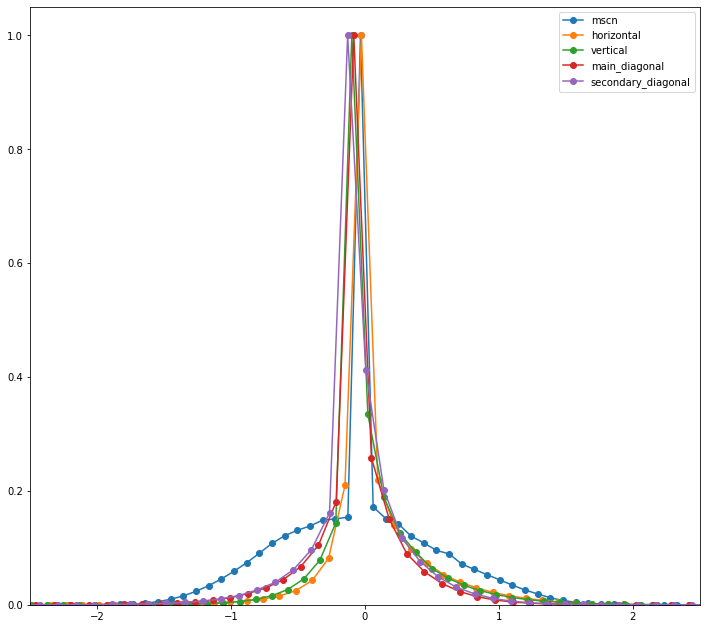

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 11

for name, coeff in coefficients.items():
    plot_histogram(coeff.ravel(), name)

plt.axis([-2.5, 2.5, 0, 1.05])
plt.legend()
plt.show()

## 3. Fit Coefficients to Generalized Gaussian Distributions 

In [ ]:
%%time 

brisque_features = calculate_brisque_features(gray_image, kernel_size=7, sigma=7/6)

CPU times: user 2.24 s, sys: 86.3 ms, total: 2.33 s
Wall time: 2.33 s


<ipython-input-10-dd988b223018>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(flatten_features)


## 4. Resize Image and Calculate BRISQUE Features

In [ ]:
%%time

downscaled_image = cv2.resize(gray_image, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
downscale_brisque_features = calculate_brisque_features(downscaled_image, kernel_size=7, sigma=7/6)

brisque_features = np.concatenate((brisque_features, downscale_brisque_features))

CPU times: user 587 ms, sys: 10.2 ms, total: 597 ms
Wall time: 614 ms


<ipython-input-10-dd988b223018>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(flatten_features)


In [46]:
def scale_features(features):
    with open('normalize.pickle', 'rb') as handle:
        scale_params = pickle.load(handle)
    
    min_ = np.array(scale_params['min_'])
    max_ = np.array(scale_params['max_'])
    
    return -1 + (2.0 / (max_ - min_) * (features - min_))

def calculate_image_quality_score(brisque_features):
    model = svmutil.svm_load_model('brisque_svm.txt')
    scaled_brisque_features = scale_features(brisque_features)
    
    x, idx = svmutil.gen_svm_nodearray(
        scaled_brisque_features,
        isKernel=(model.param.kernel_type == svmutil.PRECOMPUTED))
    
    nr_classifier = 1
    prob_estimates = (svmutil.c_double * nr_classifier)()
    
    return svmutil.libsvm.svm_predict_probability(model, x, prob_estimates)

In [47]:
%%time

calculate_image_quality_score(brisque_features)

CPU times: user 12 ms, sys: 847 µs, total: 12.9 ms
Wall time: 16.5 ms


30.73985625586826